# Audio Machine Learning Experimentation
This demo is forked from the work of [Github user](https://github.com/etown/dl1/blob/master/UrbanSoundClassification.ipynb) and [article](https://medium.com/@etown/great-results-on-audio-classification-with-fastai-library-ccaf906c5f52). The purpose is to create audio classification based on a Convolution Neural Network model.

### Import modules
- Fastai - A high level neural network modeling package written on top of PyTorch. PyTorch is installed as a dependency when Fastai is installed. Fastai is targeted at machine learning generalist.
- Librosa - For music and audio analysis. It is used for creating mel scale spectrograms in this project.
- Matplotlib - It is the underlying graphics plotting engine for creating mel scale spectrograms in this project.
- Numpy - The underlying matrix operation package for Librosa    

In [ ]:
from fastai import *
from fastai.vision import *
from pathlib import Path

import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

### Data labels
We are using NYU's Urban Sound Datasets [link](https://urbansounddataset.weebly.com/urbansound8k.html) for starter. It's a set of 8732 labelled sounds with 10 categories (e.g. gunshot, siren, dog bark). 

In [1]:
labels  = [
    'air_conditioner',
    'car_horn',
    'children_playing',
    'dog_bark',
    'drilling',
    'engine_idling',
    'gun_shot',
    'jackhammer',
    'siren',
    'street_music'
]

### Creating the spectrograms
The Urban Sound dataset audio `(*.wav)` files are split into 10 folders. The purpose is to perform 10-fold cross validation using the provided folds and report the average accuracy score. An example of cross validation is to train on folds 1 to 9, test on fold 10 and report a single accuracy score. This is standard practice in the literature and thus allows us to use the average score to compare the model's performance with those in the literature.

The following function uses Librosa to load the audio file ([API doc](https://librosa.github.io/librosa/generated/librosa.core.load.html)), each 4 seconds or less. By default, the audio file is converted to mono and resampled at 22050hz. It creates a plot canvas of size 0.72 inch by 0.72 inch and sets up a single graph using [add_subplot](https://stackoverflow.com/questions/3584805/in-matplotlib-what-does-the-argument-mean-in-fig-add-subplot111). The [mel-scaled](https://en.wikipedia.org/wiki/Mel_scale) spectrogram in Numpy matrix form is created using [librosa.feature.melspectrogram](https://librosa.github.io/librosa/generated/librosa.feature.melspectrogram.html). The [librosa.display.specshow](https://librosa.github.io/librosa/generated/librosa.display.specshow.html) then creates the diagram with colors representing [decibel units](https://librosa.github.io/librosa/generated/librosa.core.power_to_db.html).

The spectrograms are organized in the spectrogram directory:
```
spectrogram
  └───1
  │   └───7061-6-0-0.png
  |   └───7383-3-0-0.png
  │   └───...
  │ 
  └───2
  │   └───4201-3-0-0.png
  │   └───...
  │ 
  └───3
  │
  ...
```


In [ ]:
def create_fold_spectrograms(fold):
    spectrogram_path = Path('./data/partial/UrbanSound8K/spectrogram/')
    audio_path = Path('./data/partial/UrbanSound8K/audio/')
    print(f'Processing fold {fold}')
    os.mkdir(spectrogram_path/fold)
    for audio_file in list(Path(audio_path/f'fold{fold}').glob('*.wav')):
        samples, sample_rate = librosa.load(audio_file)
        fig = plt.figure(figsize=[0.72,0.72])
        ax = fig.add_subplot(111)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        filename  = spectrogram_path/fold/Path(audio_file).name.replace('.wav','.png')
        S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
        plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
        plt.close('all')

for i in range(1, 11):
    create_fold_spectrograms(str(i))

### Sample spectrograms

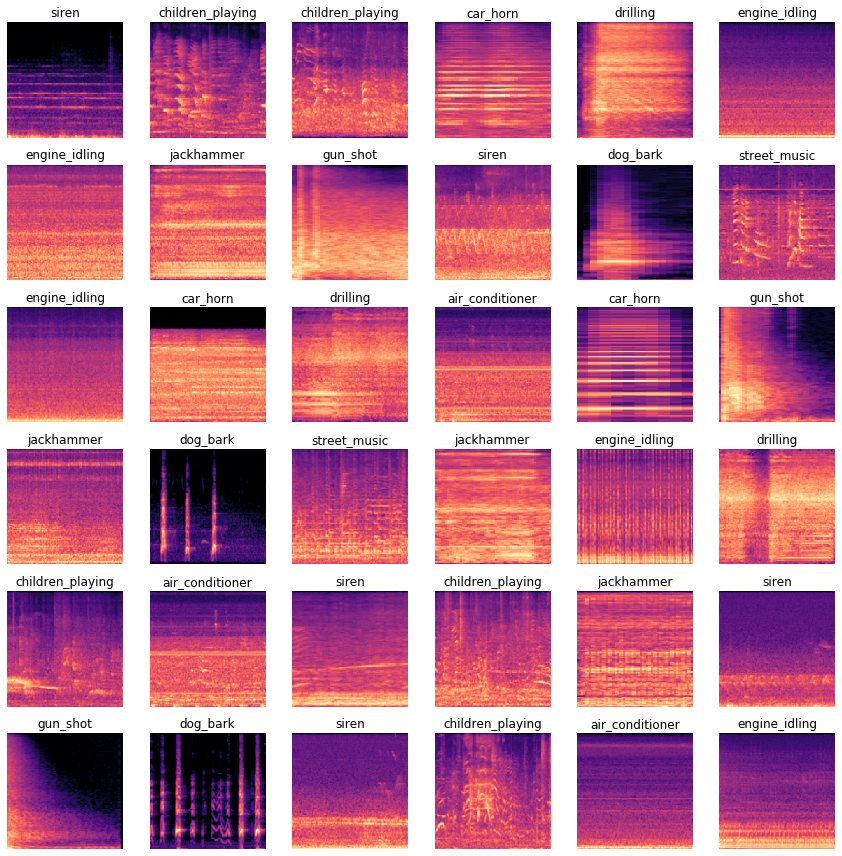

In [2]:
data_directory = Path('./data/partial/UrbanSound8K/data')
data = ImageDataBunch.from_folder(data_directory/'1', ds_tfms=[], size=224)
data.normalize(imagenet_stats)
data.show_batch(rows=6, figsize=(12,12))

### Preparing the training datasets
Organize the spectrograms into an [Imagenet-style](https://docs.fast.ai/vision.data.html#ImageDataBunch.from_folder), multi-fold directory structure.
```
data
  └───1
  │   └───train
  │   │   └───air_conditioner
  │   │   └───car_horn
  │   │   └───children_playing
  │   │   └───dog_bark
  │   │   └───...
  │   └───valid
  │       └───air_conditioner
  │       └───car_horn
  │       └───children_playing
  │       └───dog_bark
  │       └───...
  └───2
  └───3
```

For fold 1, the validation set comprises the spectrograms from the previous spectrogram folder 1. The training set of fold 1 comprises spectrograms from previous spectrogram folders 2 to 10. For fold 2, the validation set is the spectrograms from folder 2. The training set comprises spectrograms from folders 1, and 3 to 10. The same idea applies for fold 3 onwards.  

In [ ]:
def create_fold_directory(fold):
    png_files = list(Path(spectrogram_path / fold).glob('*.png'))
    os.mkdir(data_path / fold)
    os.mkdir(data_path / fold / 'train')
    os.mkdir(data_path / fold / 'valid')
    for label in labels:
        os.mkdir(data_path / fold / 'train' / label)
        os.mkdir(data_path / fold / 'valid' / label)

    for file in png_files:
        label = file.as_posix().split('-')[1]
        shutil.copyfile(file, data_path / fold / 'valid' / labels[int(label)] / file.name)
    
    for i in range(1, 11):
        if str(i) == fold:
            continue
        png_files = list(Path(spectrogram_path / str(i)).glob('*.png'))
        for file in png_files:
            label = file.as_posix().split('-')[1]
            shutil.copyfile(file, data_path / fold / 'train' / labels[int(label)] / file.name)

for i in range(1, 11):
    create_fold_directory(str(i))

### Training the model
Using Fastai, we load the image data using ImageDataBunch class, with no transformation to images(ds_tfms=`[]`), except:

  - image sized to 224x224 pixels which is [common](https://news.ycombinator.com/item?id=12509852) for Convolution Neural Network computer vision machine learning, 
  - normalization (see [this](https://docs.fast.ai/vision.data.html#ImageDataBunch.normalize) and [this](https://arthurdouillard.com/post/normalization/)) using ImageNet's 3-channel (RGB) mean (0.485, 0.456, 0.406) and standard deviation (0.229, 0.224, 0.225)

We are using CNN transfer learning with [resnet34](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8).

Regarding fit_one_cycle(n) method ([reference](https://becominghuman.ai/image-classification-using-fastai-c920dab740d)):

>```After the model is designed and compiled, FastAI uses fit_one_cycle(n) method instead of the generic fit method. The fit method is the “normal” way of training a neural net with a constant learning rate, whilst the fit_one_cycle method uses something called the 1 cycle policy, which basically changes the learning rate over time to achieve better results. n denotes the epochs (cycles for which the model goes over the data). Once the model is fitted on the training set, the weights (and other info) about the model can be saved using the following command and can be retrieved later.```

In [ ]:
def process_fold(fold):
    data_directory = Path('./data/partial/UrbanSound8K/data')
    data = ImageDataBunch.from_folder(data_directory/fold, ds_tfms=[], size=224)
    data.normalize(imagenet_stats)
    learn = cnn_learner(data, models.resnet34, metrics=accuracy)
    learn.fit_one_cycle(3)
    learn.unfreeze()
    learn.fit_one_cycle(1)
    learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

for i in range(1, 11):
    process_fold(str(i))